# Get TTN from trained MPS
## Example from qtleaves

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qtealeaves.emulator import MPS, TTN
from qtealeaves.convergence_parameters import TNConvergenceParameters


def generate_stripe_image(image_size, conv_params, vertical=True):
    """
    Generate an image with stripes in MPS form

    Parameters
    ----------
    image_size : tuple
        Shape of the image
    conv_params : TNConvergenceParameters
        Convergence parameters of the MPS
    vertical : bool, optional
        Direction of the stripes, by default True

    Returns
    -------
    MPS
        MPS representation of the image
    """
    image = np.zeros(image_size)

    if vertical:
        image[:, np.random.randint(0, image_size[1])] = 1
    else:
        image[np.random.randint(0, image_size[0]), :] = 1
    image += np.random.normal(0, 0.1, np.prod(image_size)).reshape(image_size)
    tensorlist = [
        np.array([np.cos(pixel), np.sin(pixel)]).reshape(1, 2, 1)
        for pixel in image.reshape(-1)
    ]
    mps_image = MPS.from_tensor_list(tensorlist, conv_params)
    mps_image.right_canonize(0)
    mps_image.normalize()

    return mps_image

def learning_rate(x_value):
    """ Learning rate, exponentially decaying """
    return np.exp(-x_value)
    

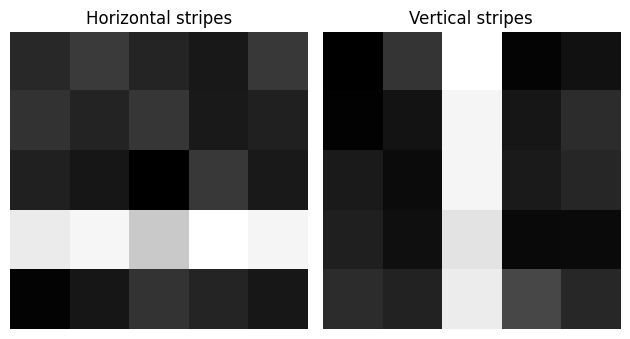

In [2]:
# show data
image_size = (5, 5) 
image_v, image_o = np.zeros((2,)+image_size)
image_o[np.random.randint(0, image_size[0]), :] = 1
image_v[:, np.random.randint(0, image_size[1])] = 1
image_o += np.random.normal(0, 0.1, np.prod(image_size)).reshape(image_size)
image_v += np.random.normal(0, 0.1, np.prod(image_size)).reshape(image_size)

# plot images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image_o, cmap="gray")
axs[0].set_title("Horizontal stripes")
axs[0].axis("off")
axs[1].imshow(image_v, cmap="gray")
axs[1].set_title("Vertical stripes")
axs[1].axis("off")
plt.tight_layout()
plt.show()

In [5]:
# generate a stripe images dataset in numpy arrays
image_size = (5, 5)
train_size = 10000
test_size = 1000

train_dataset = np.zeros((train_size,)+image_size)
train_labels = np.zeros(train_size, dtype=np.int64)

vertical_idx = np.random.choice(train_size, int(train_size/2), replace=False)
horizontal_idx = np.array([ii for ii in range(train_size) if ii not in vertical_idx])
vertical_stripes_idx = np.random.choice(image_size[1], int(train_size/2), replace=True)
horizontal_stripes_idx = np.random.choice(image_size[0], int(train_size/2), replace=True)

train_dataset[vertical_idx, :, vertical_stripes_idx] = 1
train_dataset[horizontal_idx, horizontal_stripes_idx, :] = 1
train_dataset += np.random.normal(0, 0.1, np.prod(image_size)*train_size).reshape(train_size, *image_size)
train_labels[vertical_idx] = 1

test_dataset = np.zeros((test_size,)+image_size)
test_labels = np.zeros(test_size, dtype=np.int64)

vertical_idx = np.random.choice(test_size, int(test_size/2), replace=False)
horizontal_idx = np.array([ii for ii in range(test_size) if ii not in vertical_idx])
vertical_stripes_idx = np.random.choice(image_size[1], int(test_size/2), replace=True)
horizontal_stripes_idx = np.random.choice(image_size[0], int(test_size/2), replace=True)

test_dataset[vertical_idx, :, vertical_stripes_idx] = 1
test_dataset[horizontal_idx, horizontal_stripes_idx, :] = 1
test_dataset += np.random.normal(0, 0.1, np.prod(image_size)*test_size).reshape(test_size, *image_size)
test_labels[vertical_idx] = 1

np.save(f"data/stripeimages/{image_size[0]}train.npy", train_dataset)
np.save(f"data/stripeimages/{image_size[0]}train_labels.npy", train_labels)
np.save(f"data/stripeimages/{image_size[0]}test.npy", test_dataset)
np.save(f"data/stripeimages/{image_size[0]}test_labels.npy", test_labels)

In [10]:
image_size_ = (4, 4)
train_size = 100
test_size = 10
batch_size_ = 20
num_sweeps_ = 20
conv_parameters = TNConvergenceParameters(max_bond_dimension=16)
'''
dataset = [
    generate_stripe_image(image_size_, conv_parameters, ii % 2) for ii in range(train_size)
]
labels = np.array([ii % 2 for ii in range(train_size)])
'''
dataset = np.load(f"data/stripeimages/{image_size_[0]}train.npy")[:train_size]
labels = np.load(f"data/stripeimages/{image_size_[0]}train_labels.npy")[:train_size]
dataset = [MPS.from_tensor_list([np.stack([np.cos(pixel), np.sin(pixel)]).reshape(1,2,1) for pixel in image.reshape(-1)], conv_parameters) for image in dataset]
classificator = MPS(np.prod(image_size_), conv_parameters)

svd, losses = classificator.ml_optimize_mps(
    dataset, labels, batch_size_, learning_rate, num_sweeps_, 6, True
)

predictions = classificator.ml_predict(dataset, 6)
print(f"Train accuracy: {np.sum(1-np.abs(labels-predictions))/train_size}")

test_dataset = [
    generate_stripe_image(image_size_, conv_parameters, ii % 2) for ii in range(test_size)
]
test_labels = np.array([ii % 2 for ii in range(test_size)])

predictions = classificator.ml_predict(test_dataset, 6)
print(f"Test accuracy: {np.sum(1-np.abs(test_labels-predictions))/test_size}")


==================== Sweep 0 started ====================
Sweep loss: 2.5440238161833513
==================== Sweep 1 started ====================
Sweep loss: 1.1750190288429427
==================== Sweep 2 started ====================
Sweep loss: 1.377080758211696
==================== Sweep 3 started ====================
Sweep loss: 0.9346972033336115
==================== Sweep 4 started ====================
Sweep loss: -0.3873941090910938
==================== Sweep 5 started ====================
Sweep loss: -0.10098946237732749
==================== Sweep 6 started ====================
Sweep loss: -0.16884210183663195
==================== Sweep 7 started ====================
Sweep loss: 0.5644892491288707
==================== Sweep 8 started ====================
Sweep loss: 0.21998726826681203
==================== Sweep 9 started ====================
Sweep loss: 0.383932678350852
==================== Sweep 10 started ====================
Sweep loss: 0.05446985151151886
===============

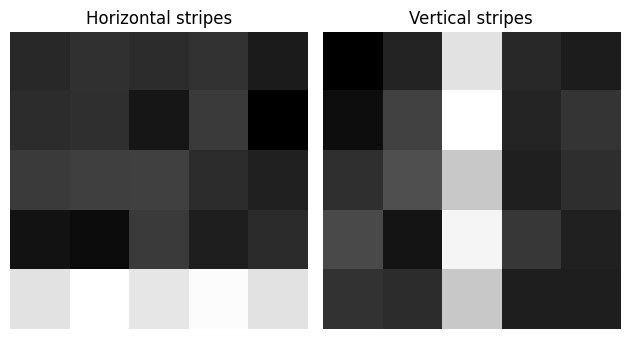

In [7]:
# plot images
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_dataset[train_labels==0][20], cmap="gray")
axs[0].set_title("Horizontal stripes")
axs[0].axis("off")
axs[1].imshow(train_dataset[train_labels==1][20], cmap="gray")
axs[1].set_title("Vertical stripes")
axs[1].axis("off")
plt.tight_layout()
plt.show()

## Adapt to MNIST test case
### Generate dataset and convert to MPS

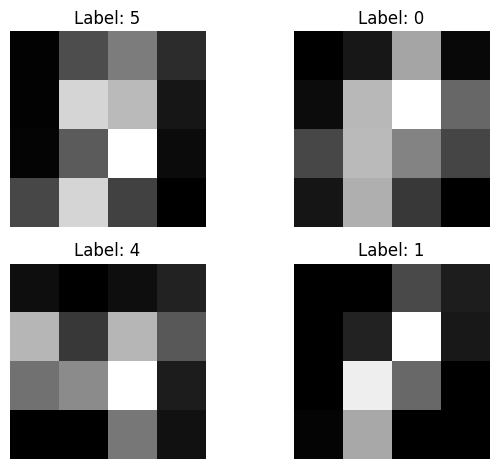

In [8]:
from PIL import Image

image_size_ = (4, 4)

def convert_to_mps(image, conv_params):
    """ Convert an image to MPS """
    tensorlist = [
        np.array([np.cos(pixel), np.sin(pixel)]).reshape(1, 2, 1)
        for pixel in image.reshape(-1)
    ]
    mps_image = MPS.from_tensor_list(tensorlist, conv_params)
    mps_image.right_canonize(0)
    mps_image.normalize()
    return mps_image

with open("data/MNIST/raw/train-images-idx3-ubyte", "rb") as f:
    raw_train = f.read()
train = np.frombuffer(raw_train, dtype=np.uint8, offset=16).reshape(-1, 28, 28)
# resize images
train = np.array([np.array(Image.fromarray(image).resize(image_size_)) for image in train]).astype(np.float64)

with open("data/MNIST/raw/train-labels-idx1-ubyte", "rb") as f:
    raw_train_labels = f.read()
train_labels = np.frombuffer(raw_train_labels, dtype=np.uint8, offset=8)

with open("data/MNIST/raw/t10k-images-idx3-ubyte", "rb") as f:
    raw_test = f.read()
test = np.frombuffer(raw_test, dtype=np.uint8, offset=16).reshape(-1, 28, 28)
# resize images
test = np.array([np.array(Image.fromarray(image).resize(image_size_)) for image in test]).astype(np.float64)

with open("data/MNIST/raw/t10k-labels-idx1-ubyte", "rb") as f:
    raw_test_labels = f.read()
test_labels = np.frombuffer(raw_test_labels, dtype=np.uint8, offset=8)

# plot a few images
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(train[i], cmap="gray")
    ax.set_title(f"Label: {train_labels[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [19]:
# hyperparameters
conv_parameters = TNConvergenceParameters(max_bond_dimension=16)
labels_to_keep = [0, 1]
TRAIN_SIZE = 100
SWEEPS = 25
BATCH_SIZE = None

In [20]:
# convert to MPS ! this takes a minute to run !
train_dataset = [(convert_to_mps(image, conv_parameters), label) for image, label in zip(train[:TRAIN_SIZE], train_labels[:TRAIN_SIZE]) if label in labels_to_keep]
test_dataset = [(convert_to_mps(image, conv_parameters), label) for image, label in zip(test[:TRAIN_SIZE], test_labels[:TRAIN_SIZE]) if label in labels_to_keep]

train_size = len(train_dataset)
test_size = len(test_dataset)
print(f"Train size: {train_size}", f"Test size: {test_size}", sep="\n")
BATCH_SIZE = train_size

Train size: 27
Test size: 22


In [21]:
# train the MPS
classificator = MPS(np.prod(image_size_), conv_parameters)

data, labels = zip(*train_dataset)
labels = np.array(labels)   # convert to numpy array as the classificator wants it
svd, losses = classificator.ml_optimize_mps(
    data, labels, BATCH_SIZE, learning_rate, SWEEPS, 6, True
)

predictions = classificator.ml_predict(data, 6)
print(f"Train accuracy: {np.sum(1-np.abs(labels-predictions))/train_size}")

==================== Sweep 0 started ====================
Sweep loss: 37.33137131831158
==================== Sweep 1 started ====================
Sweep loss: 41.99648742090557
==================== Sweep 2 started ====================
Sweep loss: 37.32708002262177
==================== Sweep 3 started ====================
Sweep loss: 35.00117014780204
==================== Sweep 4 started ====================
Sweep loss: 34.994701857381045
==================== Sweep 5 started ====================
Sweep loss: 25.65271476113529
==================== Sweep 6 started ====================
Sweep loss: 37.32800142060416
==================== Sweep 7 started ====================
Sweep loss: 27.987265498055848
==================== Sweep 8 started ====================
Sweep loss: 18.65488141875517
==================== Sweep 9 started ====================
Sweep loss: 37.30926523246498
==================== Sweep 10 started ====================
Sweep loss: 37.318556029288054
==================== Sweep 1

In [49]:
# test the MPS
data, labels = zip(*test_dataset)
labels = np.array(labels)   # convert to numpy array as the classificator wants it
predictions = classificator.ml_predict(data, 6)
print(f"Test accuracy: {np.sum(1-np.abs(labels-predictions))/test_size}")

Test accuracy: 0.4028436018957346


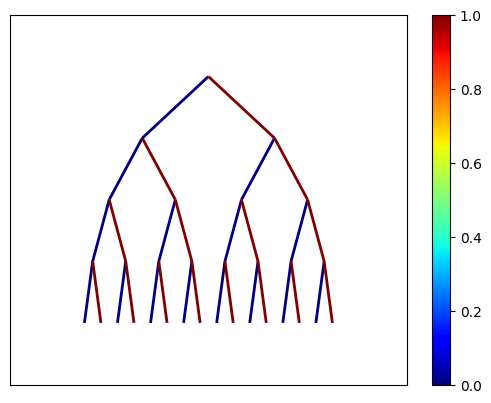

In [25]:
ttn = TTN.from_tensor_list(classificator.to_ttn())

fig, ax = plt.subplots()
ttn.plot(fig, ax, np.array([0, 1]))

In [36]:
ttn_list = ttn.to_tensor_list()
print("number of tensors:", np.array([len(ttn) for ttn in ttn_list]).sum())

number of tensors: 62
